In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor


In [52]:
supply_df = pd.read_csv('C:/Users/chimi/Desktop/Python Data Science Projects/Supply Chain Optimization/Untitled Folder 2/supply_final_modeling.csv')

In [53]:
supply_df.columns

Index(['storage_issue_reported_l3m', 'approved_wh_govt_certificate', 'wh_age',
       'transport_issue_l1y', 'temp_reg_mach', 'dist_from_hub',
       'retail_shop_num', 'retail_distributor_ratio', 'workers_num',
       'govt_check_l3m', 'product_wg_ton'],
      dtype='object')

In [54]:
supply_df.shape

(25000, 11)

In [55]:
supply_df.isnull().sum()

storage_issue_reported_l3m      0
approved_wh_govt_certificate    0
wh_age                          0
transport_issue_l1y             0
temp_reg_mach                   0
dist_from_hub                   0
retail_shop_num                 0
retail_distributor_ratio        0
workers_num                     0
govt_check_l3m                  0
product_wg_ton                  0
dtype: int64

In [56]:
supply_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   storage_issue_reported_l3m    25000 non-null  int64  
 1   approved_wh_govt_certificate  25000 non-null  int64  
 2   wh_age                        25000 non-null  float64
 3   transport_issue_l1y           25000 non-null  int64  
 4   temp_reg_mach                 25000 non-null  int64  
 5   dist_from_hub                 25000 non-null  int64  
 6   retail_shop_num               25000 non-null  int64  
 7   retail_distributor_ratio      25000 non-null  float64
 8   workers_num                   25000 non-null  float64
 9   govt_check_l3m                25000 non-null  int64  
 10  product_wg_ton                25000 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 2.1 MB


# Untuned Models:
- the purpose of this task is to rank our model without hyperparameters to determine those to tune first and get a sense of how well our models work with the unseen data.


# Cross-Validation
- A popular technique in statistics and machine learning for assessing how well a model generalizes to diverse datasets is K-Fold Cross Validation. The most popular type of cross-validation are : Leave One Out Cross Validation(LOOCV), K-Fold Cross Validation, and Stratified Cross Validation.The cross validation we will be using here is K-Fold Cross Validation. K-Fold Cross Validation divides the data into several "folds," or subsets. This strategy involves repeatedly training the model on the majority of the folds (acting as the training set), while saving one fold for testing. Each fold acts as the test set exactly once after this process is repeated, while the remaining folds operate as the entire training set. 

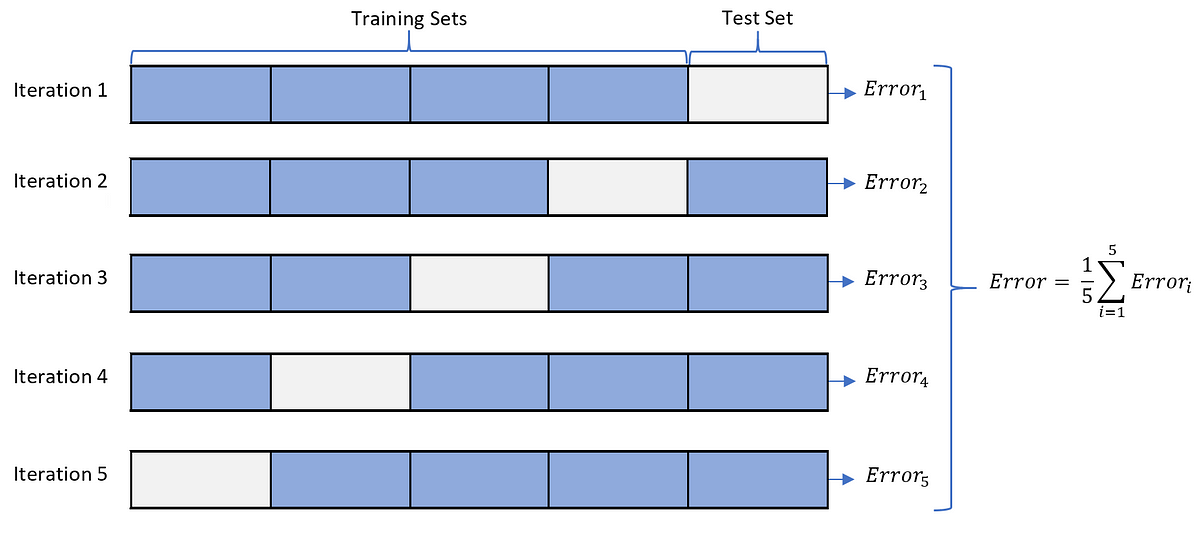

## Models that will be used :
- Linear Regression
- Regression Tree
- Decision Tree
- Random Forest
- XG BOOST
-  ADA BOOSTING
- Gradient Boosting

# Goal
- to examine the dataset performance, a number of machine learning models, ranging from Linear Regression to Boosting techniques. These models were choosen for their ability to process a wide variety of dataset. In the following results, XG-Boost exhibit the lowest MAE(Mean Absolute Error),confirming its supremacy.The reduced standard deviation indicates that the model's performance is consistent when applied to various data subsets.

In [57]:


X = supply_df.drop('product_wg_ton', axis=1)
y = supply_df['product_wg_ton']


# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )


# Define the number of folds for cross-validation
n_folds = 10

# Initialize lists to store model names, mean MAE, and std MAE
nameList_full = []
cvMeanList_full = []
cvStdList_full = []

# Define a function to calculate the negative mean absolute error (neg_mean_absolute_error)
def mae_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=2020).get_n_splits(X_train)
    mae = -cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv=kf)
    return mae

# List of regression models to evaluate
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(objective='reg:squarederror', eval_metric='mae')
]

# Loop through models, calculate mean MAE, and store results
for model in models:
    mae_scores = mae_cv(model)
    nameList_full.append(model.__class__.__name__)
    cvMeanList_full.append(mae_scores.mean())
    cvStdList_full.append(mae_scores.std())

# Create a DataFrame to store the results
untunedModel_full = pd.DataFrame({
    "Model": nameList_full,
    "Mean MAE": cvMeanList_full,
    "Std Dev MAE": cvStdList_full
})

# Display the untuned model results
untunedModel_full


,Model,Mean MAE,Std Dev MAE
0,LinearRegression,1300.051307,21.314150
1,Ridge,1300.048167,21.314812
2,Lasso,1299.832763,21.328907
3,DecisionTreeRegressor,814.238250,14.523001
4,RandomForestRegressor,677.819407,11.367385
5,ExtraTreesRegressor,681.433740,9.451312
6,AdaBoostRegressor,1408.386931,42.998350
7,GradientBoostingRegressor,673.567740,9.675842
8,XGBRegressor,662.425322,8.441391


# HyperParamater Tuning
- these are parameters that are set before the learning process start. The following examples of hyperparameters here are learning rate, n_estimators, max_depth, subsample, colsample_bytree, gamma, reg_lambda, and min_child_weight


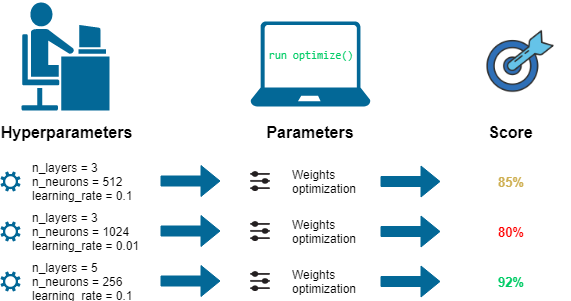

In [35]:
# Hyperparameter Tuning


# Define the parameter grid
param_distributions = {
    'learning_rate': np.arange(0.01, 0.1, 0.01),
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': range(3,10),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'min_child_weight': range(1,10)
}

# Initialize the randomized search
rs = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', eval_metric='mae', random_state=42),
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # Number of folds in cross-validation
    scoring='neg_mean_absolute_error',  # MAE as the performance measure
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search model
rs.fit(X_train, y_train)

# Get the best parameters
best_params = rs.best_params_

# Get the best score (will be in negative because of the 'neg_mean_absolute_error' metric)
best_score = -1 * rs.best_score_  # converting to positive for easier interpretation

# Print the best parameters and best score
print(f'Best parameters: {best_params}')
print(f'Best Mean Absolute Error: {best_score}')

# You can also retrieve the best estimator and use it for further predictions or analysis
best_model = rs.best_estimator_


Best parameters: {'subsample': 0.7999999999999999, 'reg_lambda': 5.0, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.02, 'gamma': 0, 'colsample_bytree': 0.8999999999999999}
Best Mean Absolute Error: 655.515490234375


In [40]:


# Initialize the XGBRegressor with the best parameters
best_xgb = XGBRegressor(
    subsample=0.8,
    reg_lambda=5.0,
    n_estimators=300,
    min_child_weight=4,
    max_depth=8,
    learning_rate=0.02,
    gamma=0,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

# Fit the model to the whole training set
best_xgb.fit(X_train, y_train)

# Predict the target on the training and test set
train_predictions = best_xgb.predict(X_train)
test_predictions = best_xgb.predict(X_test)

# Calculate the MAE on the training and test set
mae_train = mean_absolute_error(y_train, train_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)

print(f'MAE on training set: {mae_train}')
print(f'MAE on test set: {mae_test}')


MAE on training set: 579.3546274780274
MAE on test set: 644.3113216308594


In [41]:

# Calculate the R-squared value for the test set
r2 = r2_score(y_test, test_predictions)

print(f'R-squared: {r2}')


R-squared: 0.9945195781955173


In [48]:
# Making predictions on test data
predictions_on_test = best_xgb.predict(X_test)

# Adding these predictions back to your test data for comparison
X_test_with_predictions = X_test.copy()
X_test_with_predictions['predicted_product_wg_ton'] = predictions_on_test


In [50]:
# Predicted optimal weight for each warehouse on unseen data
X_test_with_predictions 

,storage_issue_reported_l3m,approved_wh_govt_certificate,wh_age,transport_issue_l1y,temp_reg_mach,dist_from_hub,retail_shop_num,retail_distributor_ratio,workers_num,govt_check_l3m,predicted_product_wg_ton
6868,5,2,5.0,3,0,90,4945,103.020833,23.0,28,6878.139648
24016,13,5,9.0,0,0,262,4779,72.409091,23.0,28,16928.052734
9668,9,4,8.0,2,1,88,4352,128.000000,19.0,15,10884.791016
13640,25,3,14.0,0,0,223,6269,223.892857,16.0,11,29308.425781
14018,15,4,14.0,0,1,129,6644,100.666667,26.0,27,18578.353516
...,...,...,...,...,...,...,...,...,...,...,...
8670,10,5,14.0,4,0,100,5163,77.059701,36.0,1,12572.973633
11839,29,5,25.0,0,0,61,4230,76.909091,25.0,9,38399.214844
4013,25,4,14.0,3,1,67,3699,77.062500,22.0,23,29727.335938
21147,5,1,14.0,2,1,208,3799,79.145833,22.0,10,6888.041504
